In [1]:
# Load the Julia environment needed for this notebook
import Pkg
Pkg.activate("../Tasks2D")

  Activating project at `~/projects/tasks2D/Tasks2D`


In [2]:
import WGLMakie, Plots    # Visualization Library
using FunctionalCollections  # PersistentVector
using Revise      # For development; makes it so modifications
                  # to imported modules are immediately reflected in this Julia session
using Gen         # Gen probabilistic programming library
import GenParticleFilters # Additional particle filtering functionality for Gen
import GridWorlds # Simple gridworld functionality
import LineWorlds: cast # Ray caster
import GenPOMDPs  # Beginnings of a Gen POMDP library

## Using Gen to define a probabilistic model of an agent in a gridworld

First, we define a prior over the agent's initial position.

In [3]:
# Initial position model

# Distribution to sample uniformly from a Julia Set
using Tasks2D.Distributions: uniform_from_set

@gen (static) function uniform_agent_pos(params)
    w = params.map # a map, represented as a GridWorlds.GridWorld
    
    pos ~ uniform_from_set(GridWorlds.empty_cells(w))
    return pos
end

var"##StaticGenFunction_uniform_agent_pos#302"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

Next, we define a motion model describing a distribution over the agent's next position,
given its previous positon and the action it takes.

In [4]:
# Motion model

@dist list_categorical(list, probs) = list[categorical(probs)]

function _get_motion_logprobs(w, (x2, y2), σ)
    possible_positions = reshape(Tuple.(keys(w)), (:,))
    logprobs = [
        w[x, y] == GridWorlds.empty ? logpdf(broadcasted_normal, [x, y], [x2, y2], σ) : -Inf
        for (x, y) in possible_positions
    ]
    return (possible_positions, logprobs)
end
_normalized_probs(lps) = exp.(lps .- logsumexp(lps))

# action `a` should be a symbol in [:up, :down, :left, :right, :stay]
@gen (static) function motion_model(pos, action, params)
    w, σ = params.map, params.step.σ
    
    new_agent_position_deterministic = GridWorlds.newpos(w, pos, action)
    (possible_positions, logprobs) = _get_motion_logprobs(
        w, new_agent_position_deterministic, σ
    )
    
    x = (@assert valid_logprobs(logprobs) "logprobs: $logprobs")
    
    pos ~ list_categorical(
        possible_positions,
        _normalized_probs(logprobs)
    )
    return pos
end

var"##StaticGenFunction_motion_model#333"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

In [5]:
function valid_logprobs(logprobs)
    return sum(exp.(logprobs .- logsumexp(logprobs))) ≈ 1.
end

valid_logprobs (generic function with 1 method)

Finally, we define an observation model.  We model the agent making noisy LIDAR distance measurements
along `n_rays` evenly spaced angles.  We model sensor error as Gaussian noise in the measured distances.

In [6]:
@gen (static) function observe_noisy_distances(pos, params)
    w, n_rays, σ = params.map, params.obs.n_rays, params.obs.σ
    
    world_with_agent = GridWorlds.place_agent(w, pos)
    dists = GridWorlds.ray_trace_distances(cast, world_with_agent, n_rays)
    obs ~ broadcasted_normal(dists, σ)
    return obs
end

var"##StaticGenFunction_observe_noisy_distances#358"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

We can define a POMDP where the state at each timestep is the agent's (x, y) position, and each observation is a vector of noisy distances measured by the agent's "LIDAR" sensor.

For now, we won't have a meaningful utility function.

In [7]:
# POMDP of this environment
pomdp = GenPOMDPs.GenPOMDP(
    uniform_agent_pos,       # INIT   : params                      ⇝ state
    motion_model,            # STEP   : prev_state, actions, params ⇝ state
    observe_noisy_distances, # OBS    : state, params               ⇝ observation
    (state, action) -> 0.    # UTILITY: state, action, params       → utility
)

GenPOMDPs.GenPOMDP(var"##StaticGenFunction_uniform_agent_pos#302"(Dict{Symbol, Any}(), Dict{Symbol, Any}()), var"##StaticGenFunction_motion_model#333"(Dict{Symbol, Any}(), Dict{Symbol, Any}()), var"##StaticGenFunction_observe_noisy_distances#358"(Dict{Symbol, Any}(), Dict{Symbol, Any}()), var"#60#61"())

We can use the GenPOMDP library to construct a probability distribution over trajectories for this POMDP, given a fixed sequence of actions the agent takes.

This probability distribution is represented as a Gen generative function.

In [8]:
# Generative function over trajectories of the POMDP,
# given a fixed action sequence.
trajectory_model = GenPOMDPs.ControlledTrajectoryModel(pomdp)

GenPOMDPs.var"##StaticGenFunction__ControlledTrajectoryModel#437"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

## Interacting with the enviornment

Let's load a gridworld map obtained by tracing a PNG file from the HouseExpo dataset.
We also need to set some parameters controlling the motion and observation model.

In [9]:
PARAMS = (
    # load houseexpo env #7,
    # discretized with 24 gridsquares along the x axis
    map = GridWorlds.load_houseexpo_gridworld(24, 7),
    
    obs  = (; n_rays = 20, σ = 0.5),
    step = (; σ = 0.3)
);

Then, we can use functionality from the GenPOMDP library to construct an interactive world state, which
we can take actions in by calling a callback function.

Specifically, `GenPOMDPs.interactive_world_trace` will give us a `take_action` callback,
and a `world_trace` object.  The `world_trace` object is an `Observable` from the Julia
`Observables` library.  An `Observable` is a pointer to an object, which also maintains a list of
"subscriber" objects.  Each time the value at the pointer changes, the Observable notifies its
subscribers of the change.

In this case, the `world_trace` object is automatically updated every time the `take_action` callback
is called with an action.  The `world_trace` is an observable over a `Trace` from Gen, for the
`trajectory_model` generative function defined above.  This trace represents a trajectory in the
POMDP, over `T` timesteps.  Each time we call `take_action(a)`, the world trace is automatically
extended by another timestep, by taking action `a`, and simulating a new random world state
and observation from the POMDP.

In [10]:
world_trace, take_action = GenPOMDPs.interactive_world_trace(trajectory_model, PARAMS);

The GridWorlds library provides visualizations which map keyboard events onto the `take_action` function above.

Use WASD to move the agent around.  Press E to have a timestep pass where the agent takes a "stay" action.
Use G to backtrack in time to view past world states.  Use T to increment time back to the current moment.  (Actions can only be taken when in the farthest simulated world state.)

In [12]:
# Map the world_trace observable to an observable
# over the sequence of ground truth positions, and observation
# point clouds.
function get_posobs_seq(groundtruth_trace)
    return map(
        trace -> (
            GenPOMDPs.state_sequence(trace),
            GenPOMDPs.observation_retval_sequence(trace)
        ),
        groundtruth_trace
    )
end

# Display this in an interactive GUI
(f, t) = GridWorlds.Viz.interactive_gui(
    PARAMS.map, get_posobs_seq(world_trace), take_action
)
f

## SLAM via Particle Filtering

Assuming that the robot doesn't know the map ahead of time, will it be able to reconstruct 
the map and localize itself simutaneously? To test this out, let's set up another generative
model to reflects the robot's internal beliefs and defines how it transists over time.

In [13]:
# Use IID Bernoulli to sample each map cell
# @dist flip_wall(wall_prob::Real) = bernoulli(wall_prob)) ? GridWorlds.wall : GridWorlds.empty
# @dist flip_wall(wall_prob::Real) = [GridWorlds.wall, GridWorlds.empty][categorical([wall_prob, 1-wall_prob])]

# ^ for whatever reason this errors out because bernoulli(wall_prob) cannot be interpreted as Bool
@gen (static) function generate_occupancy(wall_prob::Real)
    is_wall ~ bernoulli(wall_prob)
    return is_wall ? GridWorlds.wall : GridWorlds.empty
end

@gen (static) function generate_iid_bernoulli_map(width::Int, height::Int, wall_prob::Real)
    raw_map ~ Map(Map(generate_occupancy))(fill(fill(wall_prob, height), width))
    return GridWorlds.FGridWorld(raw_map, nothing, (width, height))
end

var"##StaticGenFunction_generate_iid_bernoulli_map#536"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

In [14]:
# Handle PersistentVector{Any} returns by the Map combinator
function GridWorlds.FGridWorld(grid::PersistentVector{PersistentVector{Any}}, pos::Union{Nothing, Tuple{Int, Int}}, size::Tuple{Int, Int})
    grid = PersistentVector(PersistentVector{GridWorlds.GridCell}.(grid))
    GridWorlds.FGridWorld(grid, pos, size)
end

In [15]:
# Initialize internal map by sampling each grid cell from iid Bernoulli
# and initialize position by uniformly sampling from empty location
struct State
    world::GridWorlds.GridWorld
    pos::Tuple{Number, Number}
end

@gen (static) function uniform_agent_pos_and_world(params)
    w, h, wall_prob = params.world.width, params.world.height, params.world.wall_prob

    # draw each grid iid
    world ~ generate_iid_bernoulli_map(w, h, wall_prob)
    pos ~ uniform_from_set(GridWorlds.empty_cells(world))
    return State(world, pos)
end

var"##StaticGenFunction_uniform_agent_pos_and_world#565"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

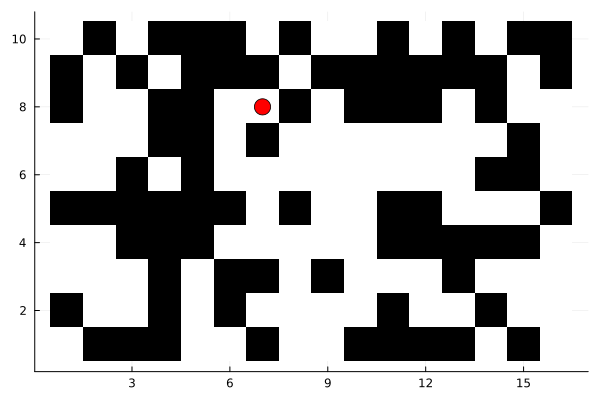

In [30]:
# let's visualize how this looks like!
function visualize_world(world::GridWorlds.GridWorld, pos::Union{Nothing, Tuple{Number, Number}}=nothing)
    width, height = size(world)
    cells = zeros(height, width)
    for (x, y) in GridWorlds.empty_cells(world)
        cells[y, x] = 1.0
    end
    plot = Plots.heatmap(cells, color = Plots.cgrad([:black, :white]), legend = :none)
    if pos != nothing
        Plots.scatter!([pos], c=:red, markersize=9, legend = :none)
    end
    return plot
end

state = uniform_agent_pos_and_world((world=(height=10, width=16, wall_prob=0.5),))
visualize_world(state.world, state.pos)

In [17]:
# For step/transition, let's define some utility functions to randomly
# flip the grids in the previous map based on a flip_prob
@gen (static) function flip_wall(flip_prob::Real, cell::GridWorlds.GridCell)
    should_flip ~ bernoulli(flip_prob)
    return should_flip ? (cell == GridWorlds.empty ? GridWorlds.wall : GridWorlds.empty) : cell
end

@gen (static) function update_iid_bernoulli_map(world::GridWorlds.GridWorld, flip_prob::Real)
    width, height = world.size
    raw_map ~ Map(Map(flip_wall))(fill(fill(flip_prob, height), width), world.cells)
    return GridWorlds.FGridWorld(raw_map, nothing, world.size)
end

var"##StaticGenFunction_update_iid_bernoulli_map#614"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

In [18]:
@gen (static) function moving_and_mapping(state::State, action, params)
    σ, flip_prob = params.step.σ, params.world.flip_prob
    world, pos = state.world, state.pos

    # Step 1: fix pos, update map
    # TODO: see if it's necessary to pass in pos as well so that the currently
    # occupied cell won't be turned into wall (it's possible that pf can filter
    # this out)
    world ~ update_iid_bernoulli_map(world, flip_prob)

    # Step 2: update agent pos
    new_agent_position_deterministic = GridWorlds.newpos(world, pos, action)
    (possible_positions, logprobs) = _get_motion_logprobs(
        world, new_agent_position_deterministic, σ
    )
    
    x = (@assert valid_logprobs(logprobs) "logprobs: $logprobs")
    
    pos ~ list_categorical(
        possible_positions,
        _normalized_probs(logprobs)
    )
    
    return State(world, pos)
end

var"##StaticGenFunction_moving_and_mapping#656"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

(7, 8)(6, 8)


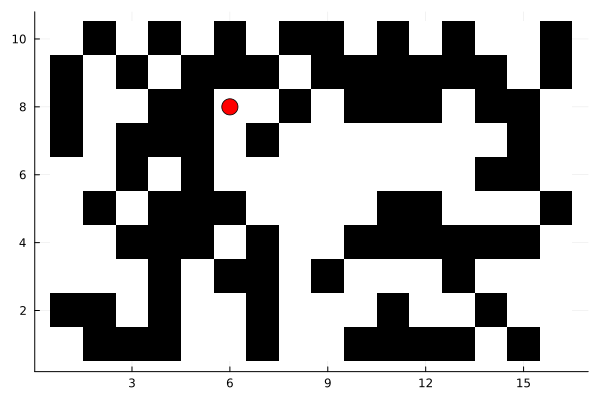

In [31]:
# let's visualize how an updated state may look like
updated_state = moving_and_mapping(state, :left, (step=(σ = 0.3,), world=(flip_prob = 0.1,)))
println(state.pos, updated_state.pos)
visualize_world(updated_state.world, updated_state.pos)

In [21]:
# the observation model is pretty much the same as before
@gen (static) function observe_noisier_distances(state::State, params)
    n_rays, σ = params.obs.n_rays, params.obs.σ
    
    world_with_agent = GridWorlds.place_agent(state.world, state.pos)
    dists = GridWorlds.ray_trace_distances(cast, world_with_agent, n_rays)
    obs ~ broadcasted_normal(dists, σ)
    return obs
end

var"##StaticGenFunction_observe_noisier_distances#686"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

In [22]:
# Now, let's set up a new POMPDPS for this model
slam_pomdp = GenPOMDPs.GenPOMDP(
    uniform_agent_pos_and_world,   # INIT   : params                      ⇝ state
    moving_and_mapping,            # STEP   : prev_state, actions, params ⇝ state
    observe_noisier_distances,     # OBS    : state, params               ⇝ observation
    (state, action) -> 0.          # UTILITY: state, action, params       → utility
)

GenPOMDPs.GenPOMDP(var"##StaticGenFunction_uniform_agent_pos_and_world#565"(Dict{Symbol, Any}(), Dict{Symbol, Any}()), var"##StaticGenFunction_moving_and_mapping#656"(Dict{Symbol, Any}(), Dict{Symbol, Any}()), var"##StaticGenFunction_observe_noisier_distances#686"(Dict{Symbol, Any}(), Dict{Symbol, Any}()), var"#183#184"())

In [64]:
width, height = size(PARAMS.map)
SLAM_PARAMS = (
    # load houseexpo env #7,
    # discretized with 24 gridsquares along the x axis
    world = (width, height, wall_prob=0.4, flip_prob=0.1),
    
    obs  = PARAMS.obs,
    step = PARAMS.step
);

Now, we'll set up another interactive session.  In this interactive session, we will route the
taken actions, and the observations generated in the POMDP simulation, to a particle filter.
We'll visualize the particles, representing the agent's location, as green squares.  The alpha
of the color will reflect the particles' weights.

For this first demo, we'll just use a bootstrap particle filter.

In [65]:
# New interactive session
world_trace2, take_action2 = GenPOMDPs.interactive_world_trace(trajectory_model, PARAMS);

# Construct an observable of the sequence of observations and actions from the
# world (consumed by inference).
function get_actobs_seq(groundtruth_trace)
    return map(
        trace -> (
            GenPOMDPs.observation_sequence(trace),
            GenPOMDPs.action_sequence(trace)
        ),
        groundtruth_trace
    )
end

# Maintain a 200-particle bootstrap particle filter,
# which updates whenever `world_trace2` updates
bootstrap_pf_states = GenPOMDPs.pf_observable(
    GenPOMDPs.bootstrap_pf(
        slam_pomdp,  # Run inference with SLAM
        SLAM_PARAMS, # with the ground-truth parameters
        200     # using 200 particles
    ),
    get_actobs_seq(world_trace2)
);

# Convert a vector of particle filter states to a vector of
# (particle filter weights, particle filter positions),
# for each timestep.  (This is the format consumed by the visualization.)
get_positions(pf_state) = map(
    (x -> x[end].pos) ∘ GenPOMDPs.state_sequence,
    GenParticleFilters.get_traces(pf_state)
) # slightly off
function pf_states_to_posweights(pf_states)
    return map(states -> ( # Map the observable to an observable over a tuple...

        # First element of the tuple: particle weights for each timestep.
        map(GenParticleFilters.get_norm_weights, states),
            
        # Second element of the tuple: particle positions for each timestep
        map(get_positions, states)

    ), pf_states)
end

# Display an interactive GUI, with the particles
(f2, t2) = GridWorlds.Viz.interactive_gui(PARAMS.map, get_posobs_seq(world_trace2), take_action2)
GridWorlds.Viz.display_pf_localization!(f2, t2, pf_states_to_posweights(bootstrap_pf_states))
f2

In [ ]:
# TODO: add visualization for internal map